In [1]:
import matplotlib.pyplot as plt
import numpy as np
import models as m
import aux_funcs as af
import os
import mi_attacks as mi
import pickle
import seaborn as sns

from collect_results import collect_rad, collect_all, collect_dp
from augmentation_combinations import get_avg_correlation, get_avg_correlation_sing
from itertools import combinations, product

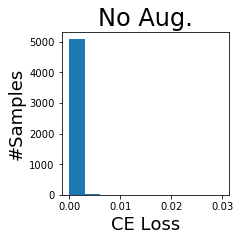

<Figure size 432x288 with 0 Axes>

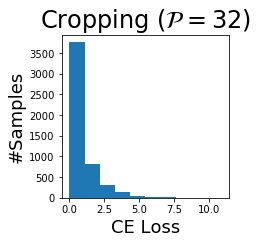

<Figure size 432x288 with 0 Axes>

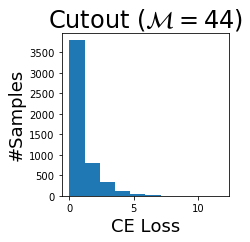

<Figure size 432x288 with 0 Axes>

In [2]:
# Section 6 --- Figure 4

def plot_loss_dist(models_path, model_name, num_attacker_train, seed, title):
    BINS = 10

    plt.figure(figsize=(3,3))

    results_path = os.path.join(models_path, model_name, f'mi_results_ntrain_{num_attacker_train}_randseed_{seed}.pickle')
    
    with open(results_path, 'rb') as handle:
        results = pickle.load(handle)

    train_losses = results['std_train_losses']
    test_losses = results['std_test_losses']


    train_acc, test_acc = results['train_top1'], results['test_top1']
    avg_atk, best_atk = results['avg_yeom_adv'], results['best_yeom_adv']


    plt.hist(train_losses, BINS)

    plt.xlabel('CE Loss', fontsize=18)
    plt.ylabel('#Samples', fontsize=18)

    plt.title(title, fontsize=24)
    plt.show()
    plt.clf()

ds_name = 'cifar10'

models_path = f'{ds_name}_models'

model_name = f'{ds_name}_laug_no_0_daug_no_0_dp_nc_0_nm_0'

plot_loss_dist(models_path, model_name, 100, 0, 'No Aug.')

model_name = f'{ds_name}_laug_no_0_daug_crop_32_dp_nc_0_nm_0'
plot_loss_dist(models_path, model_name, 100, 0, 'Cropping ($\mathcal{P}=32$)')

model_name = f'{ds_name}_laug_no_0_daug_cutout_44_dp_nc_0_nm_0'
plot_loss_dist(models_path, model_name, 100, 0, r'Cutout ($\mathcal{M}=44$)')

In [3]:
device = af.get_pytorch_device()

ds_name = 'cifar100'
models_path = f'{ds_name}_models'
train_ds, test_ds = af.get_ds(ds_name, device)
train_ds.train = False
test_ds.train = False

train_loader = af.get_loader(train_ds, shuffle=False, batch_size=500, device=device)
test_loader = af.get_loader(test_ds, shuffle=False, batch_size=500, device=device)

alphas = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


train_avg_non_max = []
test_avg_non_max = []
train_std_non_max = []
test_std_non_max = []

alphas_train = []
alphas_test = []

for alpha in alphas:
    model_name = f'{ds_name}_laug_smooth_{alpha}_daug_no_0_dp_nc_0_nm_0'
    clf = af.load_model(os.path.join(models_path, model_name, 'clf'), device)
    train_preds = m.get_clf_preds(clf, train_loader, False, 1, device)
    test_preds = m.get_clf_preds(clf, test_loader, False, 1, device)
    
    num_other_classes = clf.num_classes - 1 
    for pred in train_preds:
        train_avg_non_max.append((1 - np.max(pred))/num_other_classes)
        pred[np.argmax(pred)] = np.mean(pred)
        train_std_non_max.append(np.std(pred))
        alphas_train.append(alpha)

    for pred in test_preds:
        test_avg_non_max.append((1 - np.max(pred))/num_other_classes)
        pred[np.argmax(pred)] = np.mean(pred)
        test_std_non_max.append(np.std(pred))
        alphas_test.append(alpha)


Using PyTorch version: 1.7.1 CUDA: True
Files already downloaded and verified
Files already downloaded and verified


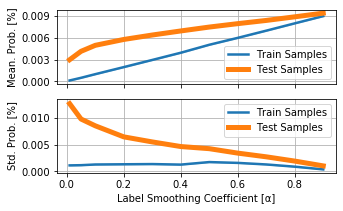

<Figure size 432x288 with 0 Axes>

In [4]:
# Section 5 --- Figure 2


import matplotlib.ticker as ticker

fig, (ax1, ax2) = plt.subplots(2, figsize=(5,3), sharex=True)


sns.lineplot(alphas_train, train_avg_non_max, label='Train Samples', ax=ax1, ci=99, linewidth=2.5)
sns.lineplot(alphas_test, test_avg_non_max, label='Test Samples', ax=ax1, ci=99, linewidth=5)

sns.lineplot(alphas_train, train_std_non_max, label='Train Samples', ax=ax2, ci=99, linewidth=2.5)
sns.lineplot(alphas_test, test_std_non_max, label='Test Samples', ax=ax2, ci=99, linewidth=5)


ax2.set_xlabel(f'Label Smoothing Coefficient [\u03B1]', fontsize=10)
ax1.set_ylabel(f'Mean. Prob. [%]', fontsize=10)
ax2.set_ylabel(f'Std. Prob. [%]', fontsize=10)

ax1.legend(loc='lower right', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))

start, end = ax1.get_ylim()
ax1.yaxis.set_ticks(np.arange(0, end, 0.003))

ax1.grid()
ax2.grid()
plt.show()
plt.clf()

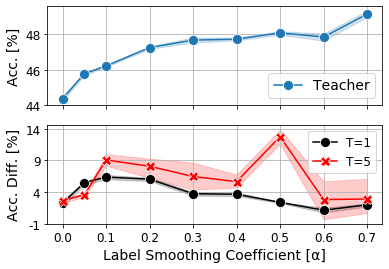

<Figure size 432x288 with 0 Axes>

In [5]:
# Section 5 - Figure 3

import matplotlib.ticker as ticker
ds_name = 'cifar100'

results_path = f'{ds_name}_smooth_vs_distillation.pickle'

if af.file_exists(results_path):
    with open(results_path, 'rb') as handle:
        results = pickle.load(handle)

num_alphas = len(results['alphas'])
num_Ts = len(results['Ts'])
num_seeds = len(results['seeds'])

dist_diffs = [[] for _ in range(num_Ts)]

alphas = np.asarray(results['alphas']).reshape(-1, 1).repeat(num_seeds)


for ii in range(num_alphas):    
    for jj in range(num_Ts):
        cur_T_diffs = []
        for kk in range(num_seeds):
            diff = results['second_student_w_dist_accs'][ii][jj][kk] - results['first_student_w_dist_accs'][ii][jj][kk]
            cur_T_diffs.append(diff)
        
        dist_diffs[jj].extend(cur_T_diffs)

fig, (ax1, ax2) = plt.subplots(2, sharex=True)

teacher_accs = []
for ii in range(num_alphas):
    teacher_accs.extend(results['teacher_accs'][ii])

sns.lineplot(alphas, teacher_accs, ax=ax1, label='Teacher', marker='o', markersize=10, ci=50)

markers = ['o', 'X']
colors = ['k', 'r']
for ii in range(num_Ts):
    sns.lineplot(alphas, dist_diffs[ii], ax=ax2, label=f'T={results["Ts"][ii]}', marker=markers[ii], color=colors[ii], markerfacecolor=colors[ii], markersize=10, ci=50)

ax2.set_xlabel(f'Label Smoothing Coefficient [\u03B1]', fontsize=14)
ax1.set_ylabel(f'Acc. [%]', fontsize=14)
ax2.set_ylabel(f'Acc. Diff. [%]', fontsize=14)

ax1.legend(loc='lower right', fontsize=14)
ax2.legend(loc='upper right', fontsize=12)

start, end = ax2.get_ylim()
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.yticks(fontsize=12)
ax2.yaxis.set_ticks(np.arange(start, end, 5))
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))


ax1.grid()
ax2.grid()
plt.show()
plt.clf()

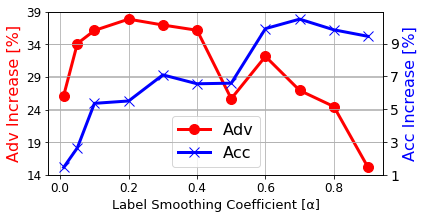

<Figure size 432x288 with 0 Axes>

In [6]:
# section 5 - Figure 1

import matplotlib.ticker as ticker


ds_names = ['cifar100']
accs = [[] for _ in ds_names]
bests = [[] for _ in ds_names]

alphas = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

rad_change = lambda before, after: 100*((after - before)/before) 


fig, ax1 = plt.subplots(figsize=(6,3))
ax2 = ax1.twinx()

ds_name = 'cifar100'
num_attacker_train = 100    
models_path = f'{ds_name}_models'
seed = 0

model_name = f'{ds_name}_laug_no_0_daug_no_0_dp_nc_0_nm_0'
results_path = os.path.join(models_path, model_name, f'mi_results_ntrain_{num_attacker_train}_randseed_{seed}.pickle')

with open(results_path, 'rb') as handle:
    results = pickle.load(handle)

bl_acc = results['test_top1']
bl_best =  results['best_yeom_adv']

accs = []
bests = []


for alpha in alphas:
    
    model_name = f'{ds_name}_laug_smooth_{alpha}_daug_no_0_dp_nc_0_nm_0'
    results_path = os.path.join(models_path, model_name, f'mi_results_ntrain_{num_attacker_train}_randseed_{seed}.pickle')

    with open(results_path, 'rb') as handle:
        results = pickle.load(handle)

    accs.append(rad_change(bl_acc, results['test_top1']))
    bests.append(rad_change(bl_best, results['best_yeom_adv']))

f = ax1.plot(alphas, bests, label='Adv', color='red', marker='o', markersize=10, linewidth=3)
s = ax2.plot(alphas, accs, label='Acc', color='blue', marker='x', markersize=10, linewidth=3)


ax1.set_xlabel(f'Label Smoothing Coefficient [\u03B1]', fontsize=13)
ax1.set_ylabel(f'Adv Increase [%]', fontsize=16, color='red')
ax2.set_ylabel(f'Acc Increase [%]', fontsize=16, color='blue')


start, end = ax1.get_ylim()
ax1.yaxis.set_ticks(np.arange(start, end, 5))

start, end = ax2.get_ylim()
ax2.yaxis.set_ticks(np.arange(start, end, 2))

ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

leg = f + s
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc='lower center', fontsize=16)

plt.yticks(fontsize=14)

ax1.grid()
ax2.grid()
plt.show()
plt.clf()

In [9]:
# section 5 - table 4

import numpy as np
from collect_results import collect_all

results = collect_all(laug_type='smooth', daug_type='crop')
ind_results = collect_all(laug_type='no', daug_type='crop')


for daug_param in results['daug_params']:
    best_acc_idx = np.argmax(results[daug_param]['acc'])
    best_adv_idx =  np.argmax(-np.asarray(results[daug_param]['best']))

    best_acc_laug_param = results[daug_param]['laug_param'][best_acc_idx]
    best_adv_laug_param = results[daug_param]['laug_param'][best_adv_idx]

    best_acc_avg =  results[daug_param]['avg'][best_acc_idx]
    best_adv_avg =  results[daug_param]['avg'][best_adv_idx]

    best_acc_acc = results[daug_param]["acc"][best_acc_idx]
    best_adv_acc = results[daug_param]["acc"][best_adv_idx]

    best_acc_adv = results[daug_param]["best"][best_acc_idx]
    best_adv_adv = results[daug_param]["best"][best_adv_idx]

    daug = results['daug_type']

    no_comb_acc = ind_results[daug_param]['acc'][0]
    no_comb_avg = ind_results[daug_param]['avg'][0]
    no_comb_best = ind_results[daug_param]['best'][0]

    print(f'Best Acc Comb Smooth + {daug}:{daug_param}:{best_acc_laug_param} --- Acc: {best_acc_acc:.2f} -- Best: {best_acc_adv:.2f} -- Avg: {best_acc_avg:.2f}')
    print(f'Best Adv Comb Smooth + {daug}:{daug_param}:{best_adv_laug_param} --- Acc: {best_adv_acc:.2f} -- Best: {best_adv_adv:.2f} -- Avg: {best_adv_avg:.2f}')
    print(f'No comb -- Acc: {no_comb_acc:.2f} -- Avg: {no_comb_avg:.2f} --- Best: {no_comb_best:.2f} ')
    print('----------------')


Best Acc Comb Smooth + crop:14:0.7 --- Acc: 56.40 -- Best: 9.31 -- Avg: 10.35
Best Adv Comb Smooth + crop:14:0.1 --- Acc: 53.94 -- Best: 6.62 -- Avg: 9.81
No comb -- Acc: 52.85 -- Avg: 8.92 --- Best: 7.07 
----------------
Best Acc Comb Smooth + crop:20:0.6 --- Acc: 45.20 -- Best: 2.81 -- Avg: 4.31
Best Adv Comb Smooth + crop:20:0.9 --- Acc: 39.90 -- Best: 1.95 -- Avg: 3.42
No comb -- Acc: 42.58 -- Avg: 4.13 --- Best: 2.90 
----------------
Best Acc Comb Smooth + crop:4:0.9 --- Acc: 64.69 -- Best: 37.61 -- Avg: 38.39
Best Adv Comb Smooth + crop:4:0.01 --- Acc: 60.16 -- Best: 33.50 -- Avg: 34.83
No comb -- Acc: 59.73 -- Avg: 32.71 --- Best: 32.03 
----------------


Baseline acc: 85.56 - Baseline Best: 28.13 - Baseline Avg: 27.69
Baseline acc: 85.76 - Baseline Best: 29.07 - Baseline Avg: 27.57
Baseline acc: 85.46 - Baseline Best: 28.08 - Baseline Avg: 26.81


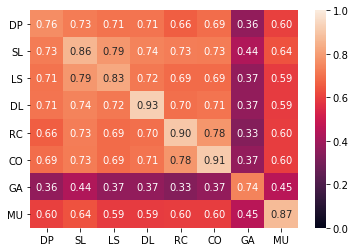

<Figure size 432x288 with 0 Axes>

In [10]:
# section 6 -- figure 6

aug_types = []

prox = 0.1
num_attacker_train = 100
seed = 0
ds_name = 'cifar10'


rad_results = {}
model_paths = [f'{ds_name}_models', f'{ds_name}_models_rep_1', f'{ds_name}_models_rep_2']
combs = list(combinations(model_paths, 2))
prods = list(product(model_paths, model_paths))

label_dict = {'DP':'dp', 'SL':'distillation', 'LS':'smooth', 'DL':'disturblabel', 'RC':'crop', 'CO':'cutout', 'GA':'noise', 'MU':'mixup'}
aug_types = ['DP', 'SL', 'LS', 'DL', 'RC', 'CO', 'GA', 'MU']


for path in model_paths:
    rad_results[path] = collect_rad(training_length='regular', capacity=1, print_results=False, aug_types=None, rad_settings=[], ds_name=ds_name, num_attacker_train=100, rank_by_acc_proximity=[prox], models_path=path)


heatmap_params = np.zeros((len(aug_types), len(aug_types)))

for ii, first_mech, in enumerate(aug_types):
    for jj, second_mech, in enumerate(aug_types):
        if ii == jj:
            for first_path, second_path in combs:
                first_model_name = os.path.basename(rad_results[first_path][label_dict[first_mech]][f'prox_{prox}']['path'])
                second_model_name = os.path.basename(rad_results[second_path][label_dict[second_mech]][f'prox_{prox}']['path'])
                cor = get_avg_correlation_sing(first_path, first_model_name, second_path, second_model_name, num_attacker_train=num_attacker_train, seed=seed)
                heatmap_params[ii,jj] += cor/(len(combs))
        else:
            for first_path, second_path in prods:
                first_model_name = os.path.basename(rad_results[first_path][label_dict[first_mech]][f'prox_{prox}']['path'])
                second_model_name = os.path.basename(rad_results[second_path][label_dict[second_mech]][f'prox_{prox}']['path'])
                cor = get_avg_correlation_sing(first_path, first_model_name, second_path, second_model_name, num_attacker_train=num_attacker_train, seed=seed)
                heatmap_params[ii,jj] += cor/(len(prods))

sns.heatmap(heatmap_params, vmin=0, vmax=1, annot=True, fmt='0.2f', xticklabels=aug_types, yticklabels=aug_types)
plt.yticks(rotation=0)
plt.show()
plt.clf()

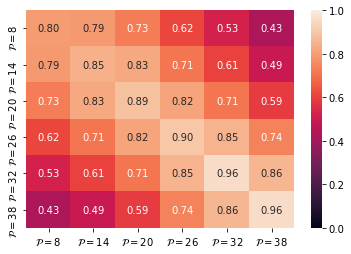

In [11]:
# section 6 - figure 5

aug_types = []

crop_results = collect_all(training_length='regular', capacity=1, laug_type='no', daug_type='crop', ds_name='cifar10', num_attacker_train=100)

num_attacker_train = 100
seed = 0
ds_name = 'cifar10'

crop_daug_params = [8,14,20,26,32,38]

paths = []
tags = []
for daug_param in crop_daug_params:
    paths.append(os.path.basename(crop_results[daug_param]['path'][0]))
    tag = r'$\mathcal{P}=$' + str(daug_param) 
    tags.append(tag)

heatmap_params = np.zeros((len(paths), len(paths)))

model_paths = [f'{ds_name}_models', f'{ds_name}_models_rep_1', f'{ds_name}_models_rep_2']
for ii in range(len(paths)):
    for jj in range(len(paths)):
        first_model_name = paths[ii]
        second_model_name = paths[jj]
        heatmap_params[ii,jj] = get_avg_correlation(model_paths, first_model_name, second_model_name, num_attacker_train=num_attacker_train, seed=seed)

sns.heatmap(heatmap_params, vmin=0, vmax=1, annot=True, fmt='0.2f', xticklabels=tags, yticklabels=tags)


In [14]:
ds_name = 'cifar10'

train_lengths = ['xxshort', 'xxxshort', 'xxxxshort']
short_training_paths = [f'{ds_name}_laug_no_0_daug_no_0_dp_nc_0_nm_0_length_{length}' for length in train_lengths]
short_training_tags = [r'$\mathcal{I}=7$', r'$\mathcal{I}=4$', r'$\mathcal{I}=3$']


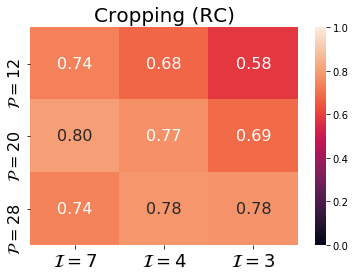

<Figure size 432x288 with 0 Axes>

In [15]:
# section 6 - figure 7a

crop_results = collect_all(training_length='regular', capacity=1, laug_type='no', daug_type='crop', ds_name='cifar10', num_attacker_train=100)

num_attacker_train = 100
seed = 0
ds_name = 'cifar10'

crop_daug_params = [12, 20, 28]

paths = []
tags = []
for daug_param in crop_daug_params:
    paths.append(os.path.basename(crop_results[daug_param]['path'][0]))
    tag = r'$\mathcal{P}=$' + str(daug_param) 
    tags.append(tag)

heatmap_params = np.zeros((len(paths), len(short_training_paths)))

model_paths = [f'{ds_name}_models', f'{ds_name}_models_rep_1', f'{ds_name}_models_rep_2']
for ii in range(len(paths)):
    for jj in range(len(short_training_paths)):
        first_model_name = paths[ii]
        second_model_name = short_training_paths[jj]
        heatmap_params[ii,jj] = get_avg_correlation(model_paths, first_model_name, second_model_name, num_attacker_train=num_attacker_train, seed=seed)

sns.heatmap(heatmap_params, vmin=0, vmax=1, annot=True, fmt='0.2f', yticklabels=tags, annot_kws={"fontsize":16}, xticklabels=short_training_tags);
plt.title('Cropping (RC)', fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(fontsize=18)

plt.show()
plt.clf()

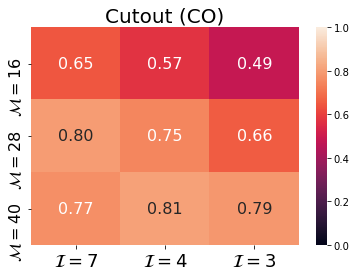

<Figure size 432x288 with 0 Axes>

In [16]:
# section 6 - figure 7b


cutout_results = collect_all(training_length='regular', capacity=1, laug_type='no', daug_type='cutout', ds_name='cifar10', num_attacker_train=100)

num_attacker_train = 100
seed = 0
ds_name = 'cifar10'

crop_daug_params = [16, 28, 40]

paths = []
tags = []
for daug_param in crop_daug_params:
    paths.append(os.path.basename(cutout_results[daug_param]['path'][0]))
    tag = r'$\mathcal{M}=$' + str(daug_param) 
    tags.append(tag)

heatmap_params = np.zeros((len(paths), len(short_training_paths)))

model_paths = [f'{ds_name}_models', f'{ds_name}_models_rep_1', f'{ds_name}_models_rep_2']
for ii in range(len(paths)):
    for jj in range(len(short_training_paths)):
        first_model_name = paths[ii]
        second_model_name = short_training_paths[jj]
        heatmap_params[ii,jj] = get_avg_correlation(model_paths, first_model_name, second_model_name, num_attacker_train=num_attacker_train, seed=seed)

sns.heatmap(heatmap_params, vmin=0, vmax=1, annot=True, fmt='0.2f', yticklabels=tags, annot_kws={"fontsize":16}, xticklabels=short_training_tags);
plt.title('Cutout (CO)', fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(fontsize=18)
plt.show()
plt.clf()

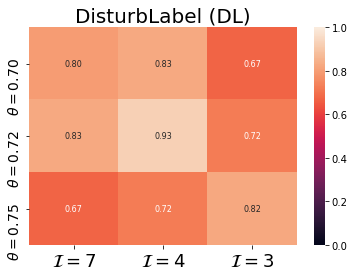

<Figure size 432x288 with 0 Axes>

In [17]:
# section 6 - figure 7c

disturblabel_results = collect_all(training_length='regular', capacity=1, laug_type='disturblabel', daug_type='no', ds_name='cifar10', num_attacker_train=100)

num_attacker_train = 100
seed = 0
ds_name = 'cifar10'

label_aug_params = [0.7, 0.725, 0.75]

all_params = disturblabel_results[0]['laug_param']
all_paths = disturblabel_results[0]['path']

paths = []
tags = []
for laug_param in label_aug_params:
    idx = all_params.index(laug_param)
    paths.append(os.path.basename(all_paths[idx]))
    tag = r'$\theta=$' + f'{laug_param:.2f}'
    tags.append(tag)

heatmap_params = np.zeros((len(paths), len(paths)))

model_paths = [f'{ds_name}_models', f'{ds_name}_models_rep_1', f'{ds_name}_models_rep_2']
for ii in range(len(paths)):
    for jj in range(len(paths)):
        first_model_name = paths[ii]
        second_model_name = paths[jj]
        heatmap_params[ii,jj] = get_avg_correlation(model_paths, first_model_name, second_model_name, num_attacker_train=num_attacker_train, seed=1)

sns.heatmap(heatmap_params, vmin=0, vmax=1, annot=True, fmt='0.2f', annot_kws={"fontsize":8}, yticklabels=tags, xticklabels=short_training_tags)
plt.title('DisturbLabel (DL)', fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=18)
plt.show()
plt.clf()

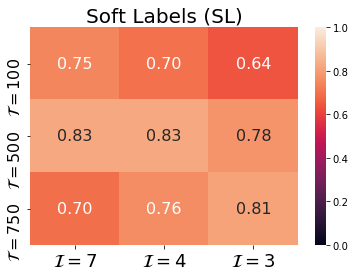

<Figure size 432x288 with 0 Axes>

In [18]:
# section 6 - figure 7d

softlabel_results = collect_all(training_length='regular', capacity=1, laug_type='distillation', daug_type='no', ds_name='cifar10', num_attacker_train=100)

num_attacker_train = 100
seed = 0
ds_name = 'cifar10'

label_aug_params = [100, 500, 750]

all_params = softlabel_results[0]['laug_param']
all_paths = softlabel_results[0]['path']

paths = []
tags = []
for laug_param in label_aug_params:
    idx = all_params.index(laug_param)
    paths.append(os.path.basename(all_paths[idx]))
    tag = r'$\mathcal{T}=$' + str(laug_param) 
    tags.append(tag)

heatmap_params = np.zeros((len(paths), len(short_training_paths)))

model_paths = [f'{ds_name}_models', f'{ds_name}_models_rep_1', f'{ds_name}_models_rep_2']
for ii in range(len(paths)):
    for jj in range(len(short_training_paths)):
        first_model_name = paths[ii]
        second_model_name = short_training_paths[jj]
        heatmap_params[ii,jj] = get_avg_correlation(model_paths, first_model_name, second_model_name, num_attacker_train=num_attacker_train, seed=seed)

sns.heatmap(heatmap_params, vmin=0, vmax=1, annot=True, fmt='0.2f', annot_kws={"fontsize":16}, yticklabels=tags, xticklabels=short_training_tags)
plt.title('Soft Labels (SL)', fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(fontsize=18)
plt.show()
plt.clf()

In [19]:
# tables 1 and 2
collect_rad(training_length='regular', capacity=1, print_results=True, aug_types=None, rad_settings=[0.1, 0.25], ds_name='fmnist', num_attacker_train=100, rank_by_acc_proximity=[]);
collect_rad(training_length='regular', capacity=1, print_results=True, aug_types=None, rad_settings=[0.1, 0.25], ds_name='cifar10', num_attacker_train=100, rank_by_acc_proximity=[]);
collect_rad(training_length='regular', capacity=1, print_results=True, aug_types=None, rad_settings=[0.1, 0.25], ds_name='cifar100', num_attacker_train=100, rank_by_acc_proximity=[]);

Baseline acc: 93.45 - Baseline Best: 8.57 - Baseline Avg: 8.63
fmnist -- max acc -- Acc: 93.24 -- Acc Drop: 0.23% - Aug dp-0.01-44743900.08 Avg: 9.03 -- Best: 9.60 
fmnist -- rad 0.1 -- Acc: 86.53 -- Acc Drop: 7.41% - Aug dp-1.0-2.71 Avg: 0.39 -- Best: 0.50 
fmnist -- rad 0.25 -- Acc: 78.72 -- Acc Drop: 15.76% - Aug dp-7.5-0.27 Avg: -0.32 -- Best: -0.14 
fmnist -- max acc -- Acc: 93.78 -- Acc Drop: -0.36% - Aug distillation-2-0.00 Avg: 4.89 -- Best: 8.29 
fmnist -- rad 0.1 -- Acc: 88.75 -- Acc Drop: 5.04% - Aug distillation-75-0.00 Avg: -0.29 -- Best: -0.17 
fmnist -- rad 0.25 -- Acc: 76.35 -- Acc Drop: 18.30% - Aug distillation-150-0.00 Avg: -0.58 -- Best: -0.21 
fmnist -- max acc -- Acc: 94.12 -- Acc Drop: -0.71% - Aug smooth-0.2-0.00 Avg: 9.98 -- Best: 17.93 
fmnist -- rad 0.1 -- Acc: 84.59 -- Acc Drop: 9.48% - Aug smooth-0.95-0.00 Avg: 0.01 -- Best: 0.84 
fmnist -- rad 0.25 -- Acc: 84.59 -- Acc Drop: 9.48% - Aug smooth-0.95-0.00 Avg: 0.01 -- Best: 0.84 
fmnist -- max acc -- Acc: 93

In [20]:
# table 3
fmnist_dp = collect_dp(training_length='regular', capacity=1, ds_name='fmnist', num_attacker_train=100)
cifar10_dp = collect_dp(training_length='regular', capacity=1, ds_name='cifar10', num_attacker_train=100)
cifar100_dp = collect_dp(training_length='regular', capacity=1, ds_name='cifar100', num_attacker_train=100)

In [21]:
print(fmnist_dp)

{0.01: {'acc': 93.23529661091324, 'best': 9.026666666666666, 'avg': 9.6, 'path': 'fmnist_models\\fmnist_laug_no_0_daug_no_0_dp_nc_1_nm_0.01'}, 0.025: {'acc': 92.8104584139157, 'best': 8.093333333333328, 'avg': 9.080000000000004, 'path': 'fmnist_models\\fmnist_laug_no_0_daug_no_0_dp_nc_1_nm_0.025'}, 0.05: {'acc': 92.3856220120698, 'best': 5.8666666666666645, 'avg': 5.933333333333333, 'path': 'fmnist_models\\fmnist_laug_no_0_daug_no_0_dp_nc_1_nm_0.05'}, 0.075: {'acc': 91.56209309895833, 'best': 5.440000000000002, 'avg': 5.433333333333333, 'path': 'fmnist_models\\fmnist_laug_no_0_daug_no_0_dp_nc_1_nm_0.075'}, 0.1: {'acc': 91.26797535216888, 'best': 3.773333333333331, 'avg': 4.359999999999999, 'path': 'fmnist_models\\fmnist_laug_no_0_daug_no_0_dp_nc_1_nm_0.1'}, 0.175: {'acc': 90.03921758115682, 'best': 2.693333333333333, 'avg': 2.953333333333333, 'path': 'fmnist_models\\fmnist_laug_no_0_daug_no_0_dp_nc_1_nm_0.175'}, 0.25: {'acc': 89.22222411710453, 'best': 2.746666666666665, 'avg': 2.92000